In [1]:
import os
import sys

# Determine the path to the root directory (one level up from the notebooks directory)
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add the root and 'src' directory to the system path
if root_dir not in sys.path:
    sys.path.append(root_dir)

src_path = os.path.join(root_dir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# PyTorch imports
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import _LRScheduler

# PyTorch Geometric imports
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, OnDiskDataset, download_url, extract_zip
from torch_geometric.data.data import BaseData, Data

# Project specific imports
from modifications.torch_geometric_modified import from_smiles
from models.AttentiveFP_v2 import AttentiveFP
from utils.data_utils import DatasetAttentiveFP, GenSplit
from utils.plot_utils import make_subplot, make_density_plot, make_subplot_v2
from loss.spectral_loss import get_spectral_fn, normalize_spectra
from filters.savitzky_golay_torch import initialize_savgol_filter
import config.params as params
from utils.sweep_utils import find_batch_size
from utils.wandb_utils import log_to_wandb
from utils.scheduler_utils import build_lr_scheduler

# Other imports
import yaml
import wandb
import argparse
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import random
import logging
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from PIL import Image

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
import pandas as pd

import torch

# Check for config_spectra.yml
config_path = os.path.join(root_dir, 'src', 'config', 'config_spectra.yml')
if not os.path.exists(config_path):
    raise FileNotFoundError("config_spectra.yml not found in the config directory")
with open(config_path) as file:
    config_spectra = yaml.load(file, Loader=yaml.FullLoader)


2024-07-09 14:30:19,361 - INFO - Enabling RDKit 2023.09.6 jupyter extensions - [__init__.py:22]


In [2]:
# Make all wavelengths integers, some are strings like '150_pred'
def make_int(x):
    try:
        return int(x)
    except:
        return int(x[:-5])


#Smiles column to string
def make_string(x):
    return str(x)

In [3]:
WORKSPACE_PATH = params.WORKSPACE_PATH
PERSISTENT_STORAGE_PATH = params.PERSISTENT_STORAGE_PATH

In [4]:
checkpoint_ids = ['0m6tuxub', 'gp6vyj9y', 'hj8vq1cz', 'i4pq2liq', 'ls72htwl', 'n2qo35iy', 'o0tiq0hd']
checkpoints_dirs = '/home/nyrenw/AttentiveFP-UV/models'

In [5]:
df = {'smiles': [], 'spectra': [], 'spectra_pred': [], 'checkpoint': []}

In [6]:
for checkpoint_id in checkpoint_ids:
    checkpoint_path = os.path.join(checkpoints_dirs, checkpoint_id)
    
    # Load config file
    with open(os.path.join(checkpoint_path, f'config_{checkpoint_id}.pkl'), 'rb') as f:
        config = pickle.load(f)

    # Load AttentiveFP model
    checkpoint = torch.load(os.path.join(checkpoint_path, f'checkpoint_{checkpoint_id}.pt'))

    default_config = config

    model = AttentiveFP(in_channels=26,
                        hidden_channels=default_config["hidden_channels"],
                        out_channels=50,
                        edge_dim=14,
                        num_layers=default_config["num_layers"],
                        num_timesteps=default_config["num_timesteps"],
                        dropout=default_config["dropout"],
                        attention_mode=default_config['Attention_mode'],
                        heads=default_config['heads']
                        )
    # Load checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    # Load model to device
    model.to('cuda')
    model.eval()

    # Load the dataset
    path_tmp = os.path.join(PERSISTENT_STORAGE_PATH, default_config['DATA_DIRECTORY'], 'test', 'data')
    dataset = DatasetAttentiveFP(root=path_tmp, split='test', one_hot=config_spectra['one_hot'], config=config_spectra)

    #Dataloader
    val_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=default_config['num_workers'], drop_last=True)

    # Eval chk_pnt and store predictions in a pd dataframe
    for i, data in enumerate(val_loader):
        data = data.to('cuda')
        with torch.no_grad():
            pred = model(data.x, data.edge_index, data.edge_attr, data.batch)
            pred = torch.pow(pred, 2)
            pred = pred/torch.max(pred, dim=1, keepdim=True)[0]
            target_spectra = data.y
            target_spectra = target_spectra/torch.max(target_spectra, dim=1, keepdim=True)[0]
            pred, target_spectra, _ = normalize_spectra(pred, target_spectra, torch_device=data.x.device)
        df['smiles'].extend(data.smiles)
        df['spectra'].extend(target_spectra.cpu().numpy())
        df['spectra_pred'].extend(pred.cpu().numpy())
        df['checkpoint'].extend([checkpoint_id]*len(data.smiles))
        if i == 100:
            break

df = pd.DataFrame(df)


In [7]:
# shape of df
print(df.shape)

(44919, 4)


In [8]:
# Sort by smiles and checkpoint
df = df.sort_values(by=['smiles', 'checkpoint'])

In [9]:
# Tidy df such that spectra arrays are in columns from 150 to 450 with 6 nm steps
df_tidy = pd.DataFrame()
# Copy of df but only with smiles and checkpoint
df_tidy = df[['smiles', 'checkpoint']]
for i, val in enumerate(range(150, 450, 6)):
    df_tidy[str(val)] = [x[i] for x in df['spectra']]
    df_tidy[str(val) + '_pred'] = [x[i] for x in df['spectra_pred']]
display(df_tidy.head(5))

,smiles,checkpoint,150,150_pred,156,156_pred,162,162_pred,168,168_pred,...,420,420_pred,426,426_pred,432,432_pred,438,438_pred,444,444_pred
6596,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,4.257106e-02,0.044632,8.376440e-02,0.073563,0.109070,0.105700,0.114443,0.146767,...,1.257549e-09,8.213149e-05,1.257549e-09,0.000001,1.257549e-09,1.861470e-08,1.257549e-09,0.000002,1.257549e-09,2.744439e-05
38111,C#CC(C)(C)C(=O)OCc1nn(Cc2ccccc2C)nc1C,n2qo35iy,1.893280e-09,0.000923,1.893280e-09,0.007747,0.001437,0.016327,0.009736,0.032559,...,1.893280e-09,2.239064e-06,1.893280e-09,0.000019,1.893280e-09,4.886870e-04,1.893280e-09,0.000235,1.893280e-09,6.439830e-06
25108,C#CC(C)(C)CC(=O)N1CCC(n2c(CC)nc3ccccc32)CC1,i4pq2liq,1.707115e-09,0.000891,3.151671e-04,0.003703,0.002097,0.013199,0.009398,0.020327,...,1.707115e-09,5.723123e-07,1.707115e-09,0.000492,1.707115e-09,4.150320e-04,1.707115e-09,0.000140,1.707115e-09,6.348333e-05
12494,C#CC(C)(C)CS(=O)(=O)N(O)CCc1ccc(N2CCOCC2)cc1,gp6vyj9y,1.041117e-09,0.000034,9.876889e-04,0.001410,0.005934,0.015487,0.022813,0.029907,...,1.041117e-09,2.862213e-06,1.041117e-09,0.000071,1.041117e-09,7.978590e-06,1.041117e-09,0.000038,1.041117e-09,7.918972e-08
14944,C#CC(C)(C)CS(=O)(=O)N(O)CCc1ccc(N2CCOCC2)cc1,hj8vq1cz,1.041117e-09,0.000439,9.876889e-04,0.002385,0.005934,0.007058,0.022813,0.020423,...,1.041117e-09,6.588751e-05,1.041117e-09,0.000211,1.041117e-09,5.910006e-05,1.041117e-09,0.000200,1.041117e-09,5.316549e-07


In [10]:
# Make df_tidy a tidy dataframe by having wavelength as rows with the corresponding spectra values and smiles
df_tidy_pred = pd.melt(df_tidy, id_vars=['smiles', 'checkpoint'], value_vars=[str(x)+'_pred' for x in range(150, 450, 6)], var_name='wavelength', value_name='spectra')
df_tidy_true = pd.melt(df_tidy, id_vars=['smiles', 'checkpoint'], value_vars=[str(x) for x in range(150, 450, 6)], var_name='wavelength', value_name='spectra')
# Add a column to specify if the spectra is predicted or true
df_tidy_pred['type'] = 'pred'
df_tidy_true['type'] = 'true'
# Merge the predicted and true spectra
df_tidy_attentive_fp_test = pd.concat([df_tidy_true, df_tidy_pred], ignore_index=True)


In [11]:
#Sort based on smiles and wavelength
df_tidy_attentive_fp_test = df_tidy_attentive_fp_test.sort_values(by=['smiles', 'wavelength'])

In [12]:
df_tidy_attentive_fp_test['wavelength'] = df_tidy_attentive_fp_test['wavelength'].apply(make_int)

<Axes: xlabel='wavelength', ylabel='spectra'>

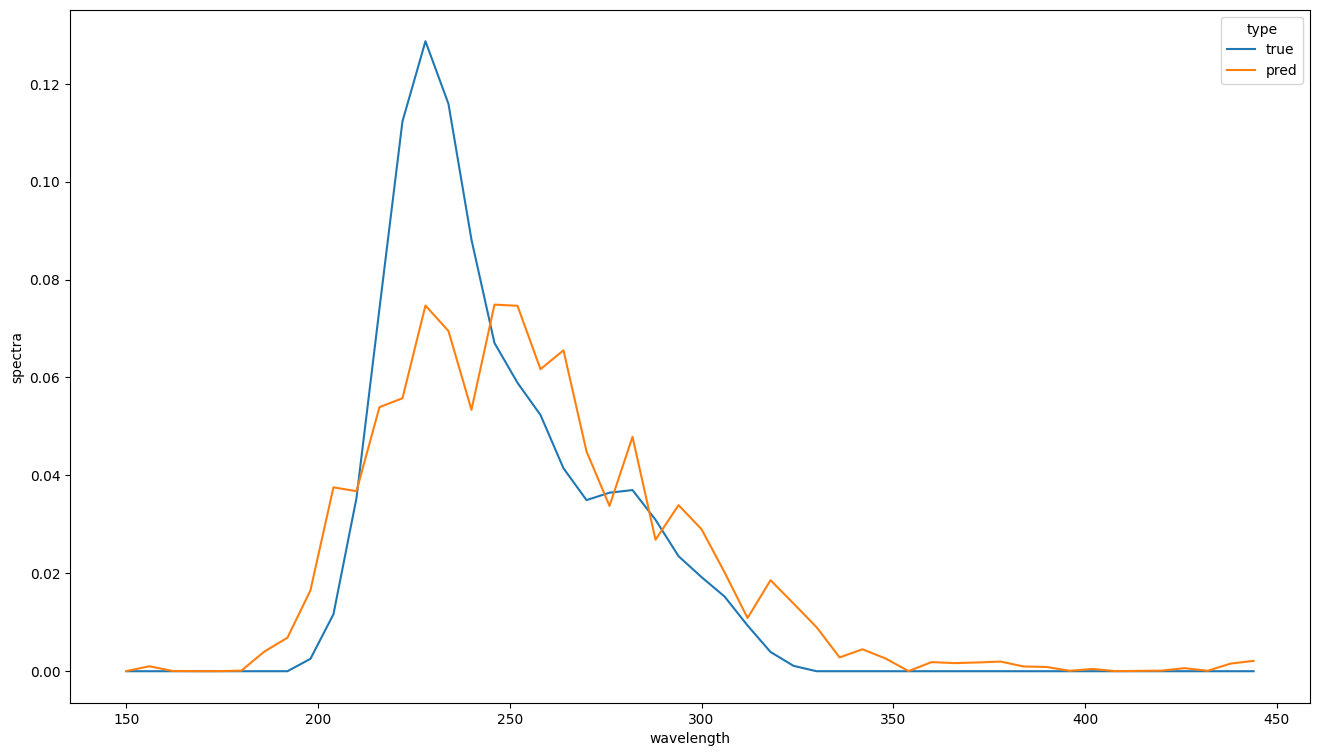

In [13]:
#plot the spectra for a specific smiles with pred vs true
#smiles = 'C#CC#CC#CC1CO1'
#Sample a smiles
smiles = random.choice(df_tidy_attentive_fp_test['smiles'].unique())
df_plot = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['smiles'] == smiles]
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_plot, x='wavelength', y='spectra', hue='type')

In [15]:
# Graoup by smiles, checkpoint and wavelength and compute the absolute error
ture_spectra = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['type'] == 'true']
pred_spectra = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['type'] == 'pred']
df_error = pd.merge(ture_spectra, pred_spectra, on=['smiles', 'checkpoint', 'wavelength'])
df_error['abs_error'] = abs(df_error['spectra_x'] - df_error['spectra_y'])
# Use only the columns smiles, checkpoint, wavelength and abs_error
df_error = df_error[['smiles', 'checkpoint', 'wavelength', 'abs_error']]
# Add column type = pred
df_error['type'] = 'pred'
# Compute the avg_abs_error for each pair of smiles and checkpoint
df_error_tmp = df_error.groupby(['smiles', 'checkpoint', 'type'])['abs_error'].mean().reset_index()
# Change name of abs_error to avg_abs_error
df_error_tmp = df_error_tmp.rename(columns={'abs_error': 'avg_abs_error'})
# Merge the avg_abs_error with the original df_error
df_error = pd.merge(df_error, df_error_tmp, on=['smiles', 'checkpoint', 'type'])

df_error_true = df_error.copy()
df_error_true['abs_error'] = 0
df_error_true['type'] = 'true'
df_error_true['avg_abs_error'] = 0

df_error = pd.concat([df_error, df_error_true], ignore_index=True)
df_error = df_error.sort_values(by=['smiles', 'wavelength', 'type', 'checkpoint'])


In [16]:
df_tidy_attentive_fp_test = df_error

,smiles,checkpoint,wavelength,abs_error,type,avg_abs_error
0,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,150,0.002061,pred,0.00518
2245950,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,150,0.000000,true,0.00000
1,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,156,0.010202,pred,0.00518
2245951,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,156,0.000000,true,0.00000
2,C#CC(=O)N(C)CCOCCNC(=O)NCCN(C)C(C)=O,gp6vyj9y,162,0.003370,pred,0.00518


In [17]:
# Add the median, mean, 25th, 75th, 95th and 99th percentile of the avg_abs_error to each corresponding chk_pnt
df_tidy_attentive_fp_test['median'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform('median')
df_tidy_attentive_fp_test['mean'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform('mean')
df_tidy_attentive_fp_test['25th'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform(lambda x: np.percentile(x, 25))
df_tidy_attentive_fp_test['75th'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform(lambda x: np.percentile(x, 75))
df_tidy_attentive_fp_test['95th'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform(lambda x: np.percentile(x, 95))
df_tidy_attentive_fp_test['99th'] = df_tidy_attentive_fp_test.groupby('checkpoint')['avg_abs_error'].transform(lambda x: np.percentile(x, 99))

gp6vyj9y
n2qo35iy
i4pq2liq
hj8vq1cz
o0tiq0hd
0m6tuxub
ls72htwl


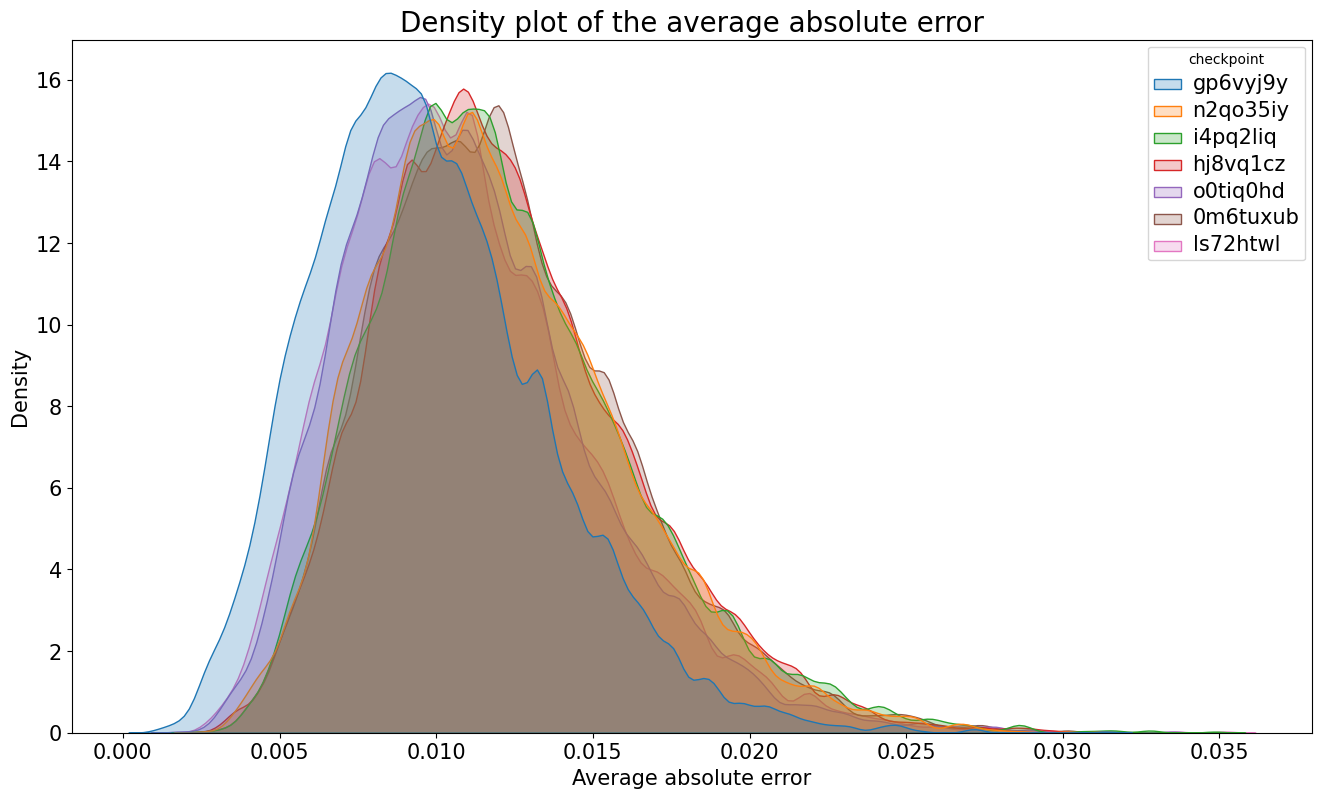

In [21]:
# Use only predictions for this plot
df_plot = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['type'] == 'pred']

# density plot with verticle lines for the median, mean, 25th, 75th, 95th and 99th percentile
plt.figure(figsize=(16,9))
ax = sns.kdeplot(data=df_plot, x='avg_abs_error', hue='checkpoint', fill=True, common_norm=True)
# Set legend text to AttentiveFP or Chemprop-IR depending on the chk_pnt
#plt.setp(ax.get_legend().get_texts()[0], text="AttentiveFP")
#plt.setp(ax.get_legend().get_texts()[1], text="Chemprop-IR")
# Legend fontsize
plt.setp(ax.get_legend().get_texts(), fontsize='15')
# Add verticle lines
for chk_pnt in df_plot['checkpoint'].unique():

    median = df_plot[df_plot['checkpoint'] == chk_pnt]['median'].values[0]
    mean = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['checkpoint'] == chk_pnt]['mean'].values[0]
    p25 = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['checkpoint'] == chk_pnt]['25th'].values[0]
    p75 = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['checkpoint'] == chk_pnt]['75th'].values[0]
    p95 = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['checkpoint'] == chk_pnt]['95th'].values[0]
    p99 = df_tidy_attentive_fp_test[df_tidy_attentive_fp_test['checkpoint'] == chk_pnt]['99th'].values[0]

    plt.title("Density plot of the average absolute error", fontsize=20)
    plt.xlabel("Average absolute error", fontsize=15)
    plt.ylabel("Density", fontsize=15)
    # Fontsize for the ticks
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
